# Аналіз жестів руки: k-NN та k-means

**Об'єкт дослідження:** гіпотетичне зображення руки  
**Ознаки:** висота та ширина долоні (2D простір)  
**Класи:** Кулак, Долоня

---
**Щоб запустити все без ноутбука:** виконайте `python run_nb.py`


In [1]:
import math
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from IPython.display import display, Image

class RNG:
    def __init__(self, seed=42):
        self.state = seed
    def random(self):
        self.state = (1103515245 * self.state + 12345) % (2**31)
        return self.state / (2**31)
    def gauss(self, mu, sigma):
        u1, u2 = self.random(), self.random()
        return mu + sigma * math.sqrt(-2 * math.log(u1 + 1e-10)) * math.cos(2 * math.pi * u2)

rng = RNG(42)
def generate_class(n, cw, ch, sw, sh):
    return [(rng.gauss(cw, sw), rng.gauss(ch, sh)) for _ in range(n)]

fist_data = generate_class(30, 8, 4, 0.8, 0.9)
palm_data = generate_class(30, 16, 16, 1.5, 1.8)
X = fist_data + palm_data
y = [0]*30 + [1]*30
fist_w = [p[0] for p in fist_data]
fist_h = [p[1] for p in fist_data]
palm_w = [p[0] for p in palm_data]
palm_h = [p[1] for p in palm_data]
print(f"Згенеровано {len(X)} зразків: {len(fist_data)} кулак, {len(palm_data)} долоня")


Згенеровано 60 зразків: 30 кулак, 30 долоня


## 1. Приклади обмежувальних рамок (3 жести)


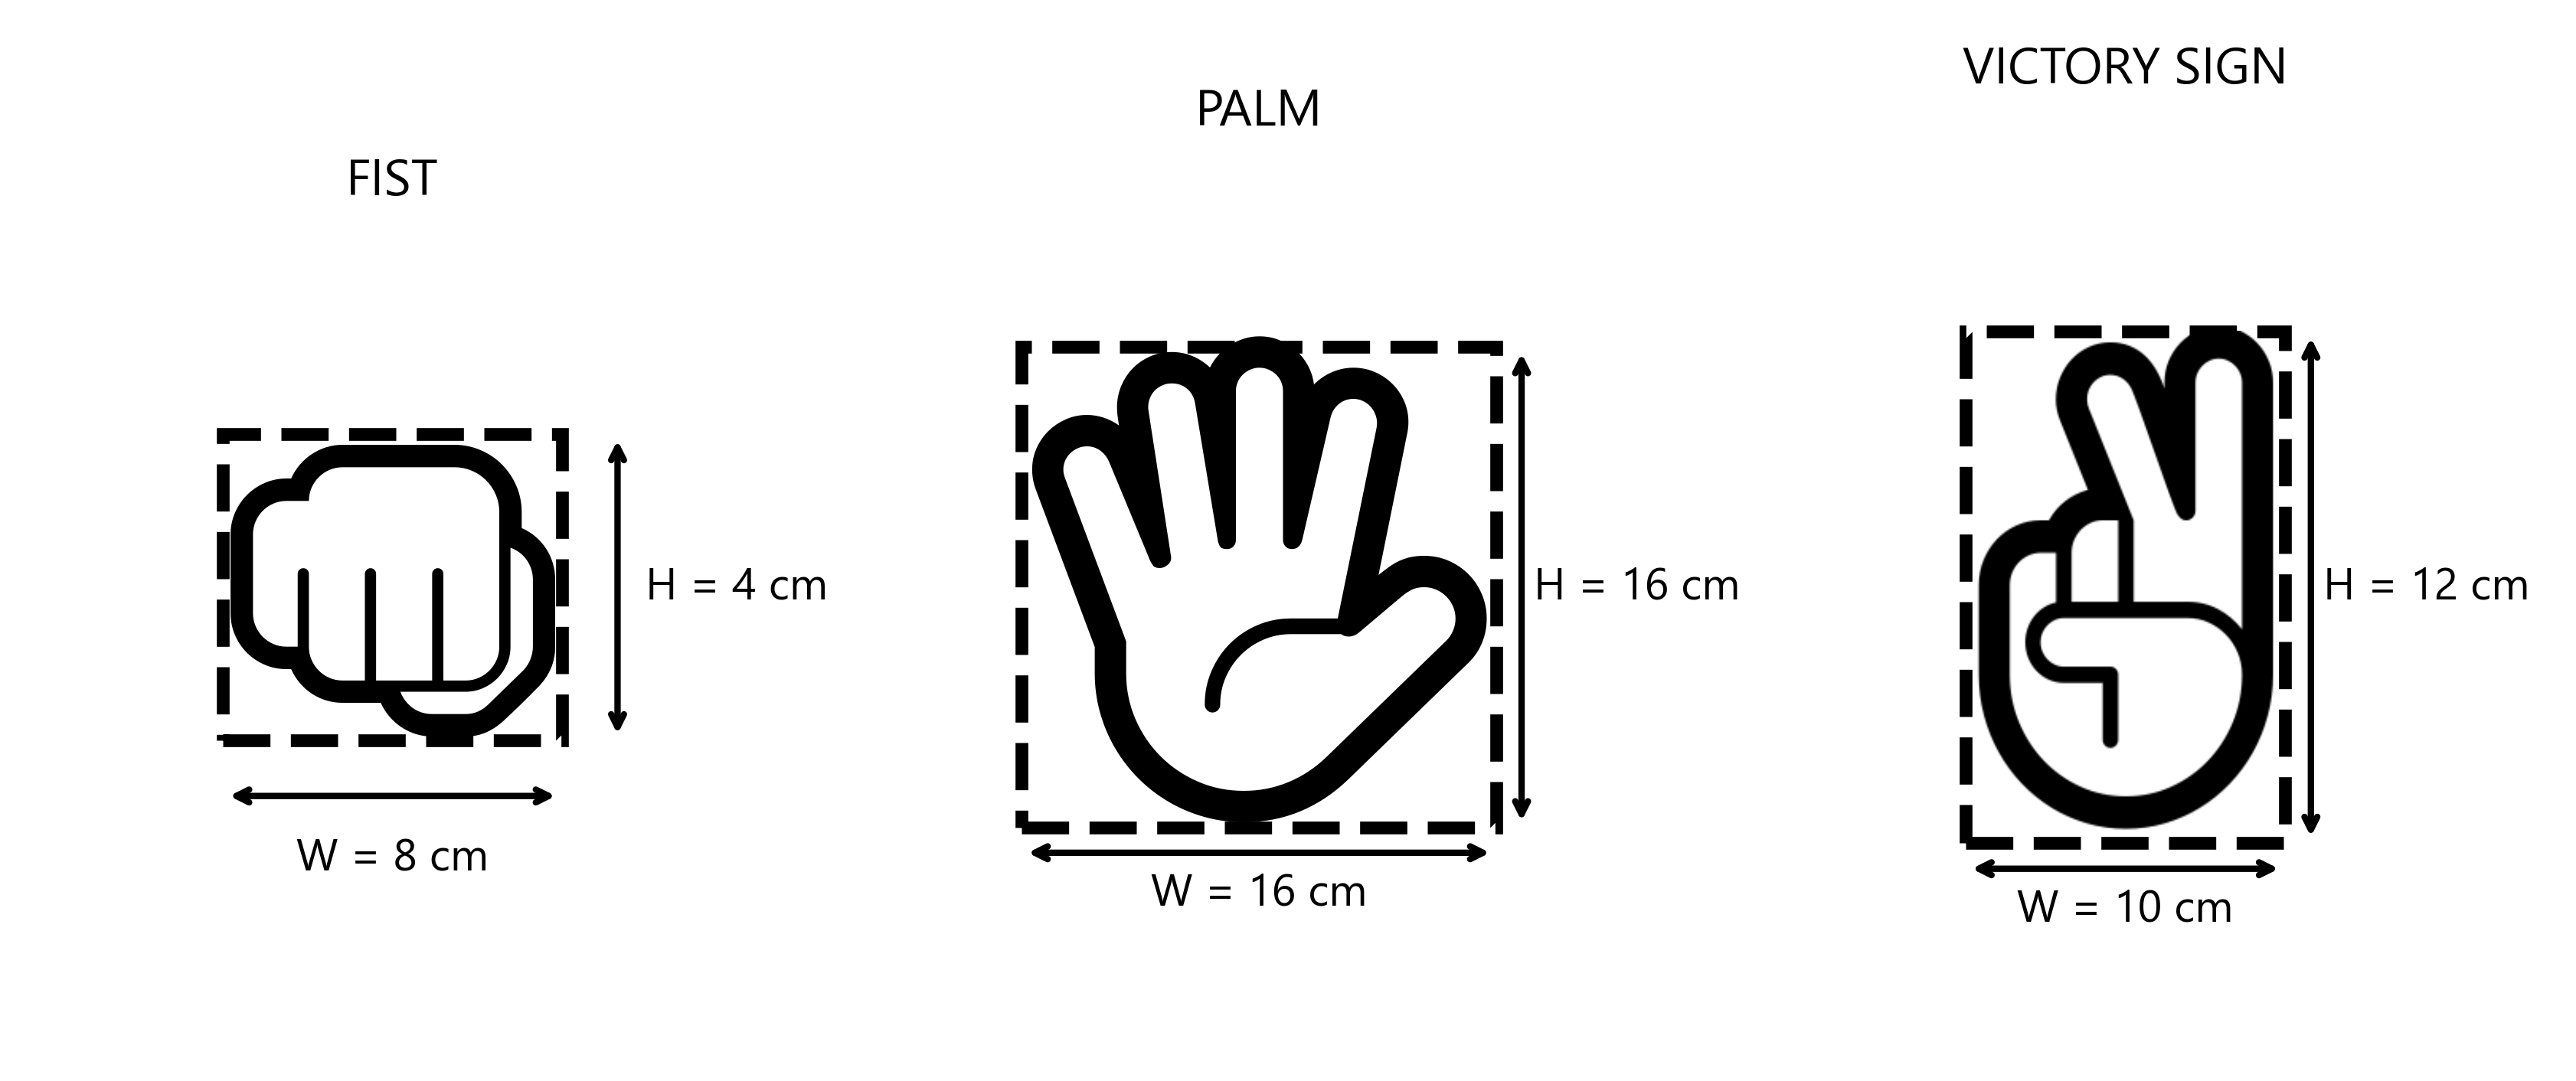

In [2]:
import subprocess
import sys
subprocess.run([sys.executable, "generate_box_examples.py"], check=True)
display(Image("box_examples.png"))


## 2. Візуалізація даних


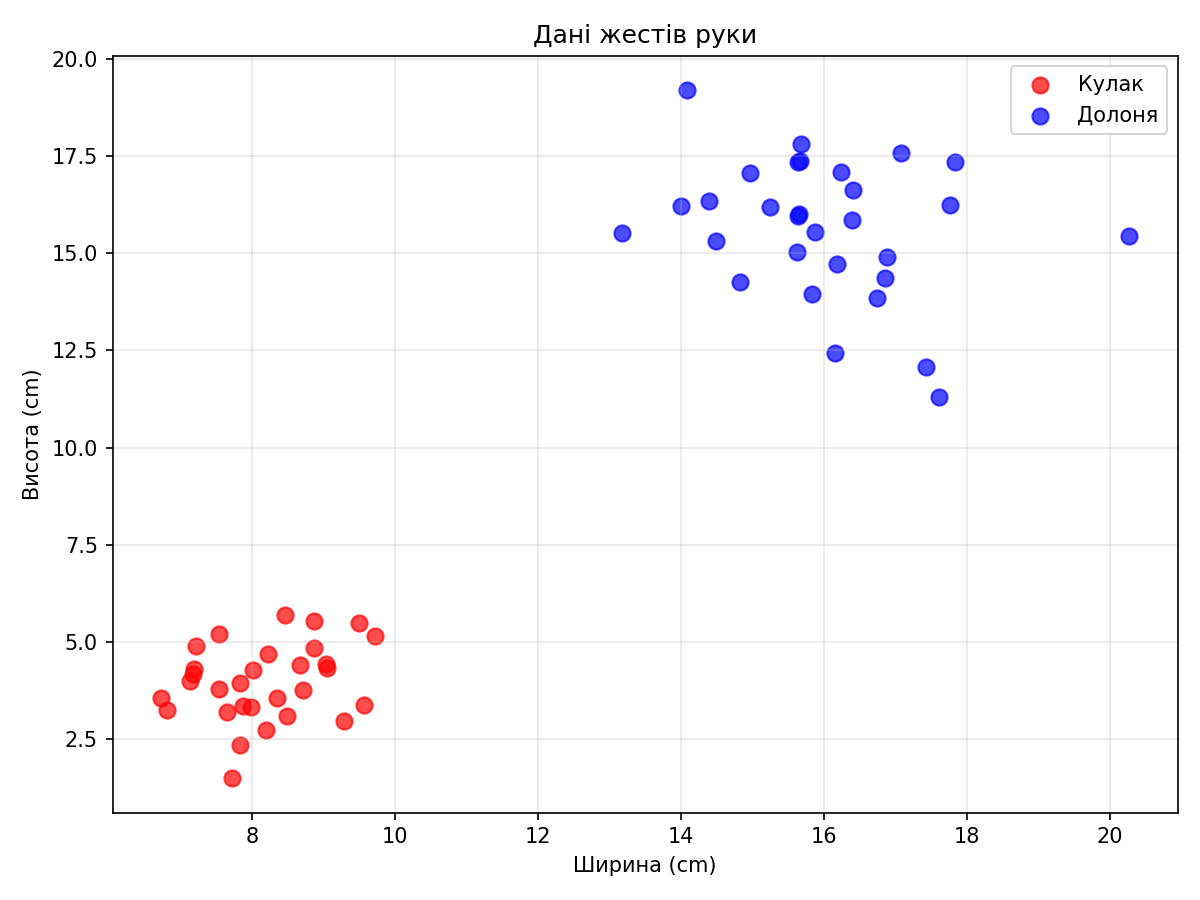

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(fist_w, fist_h, c='red', label='Кулак', s=60, alpha=0.7)
ax.scatter(palm_w, palm_h, c='blue', label='Долоня', s=60, alpha=0.7)
ax.set_xlabel('Ширина (cm)')
ax.set_ylabel('Висота (cm)')
ax.set_title('Дані жестів руки')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('data_visualization.png', dpi=150)
plt.close()
display(Image('data_visualization.png'))


## 3. k-NN класифікатор


Тренування: 48, Тест: 12
k=1: Точність = 100.0%
k=3: Точність = 100.0%
k=5: Точність = 100.0%
k=7: Точність = 100.0%


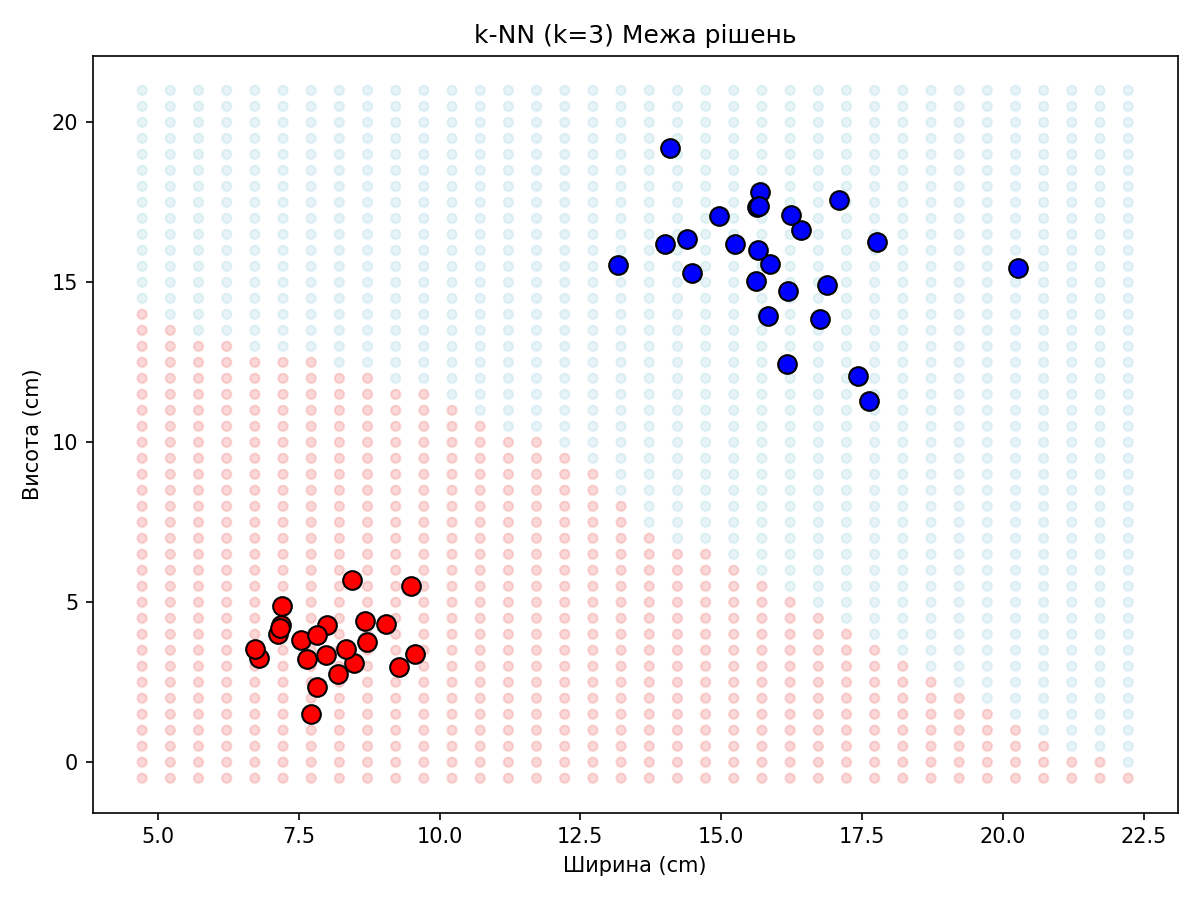

In [4]:
def euclidean_dist(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
def knn_predict(train_X, train_y, point, k=3):
    distances = sorted([(euclidean_dist(point, p), train_y[i]) for i, p in enumerate(train_X)])
    votes = {}
    for _, label in distances[:k]:
        votes[label] = votes.get(label, 0) + 1
    return max(votes, key=votes.get)
def shuffle_data(X, y, rng):
    indices = list(range(len(X)))
    for i in range(len(indices)-1, 0, -1):
        j = int(rng.random() * (i+1))
        indices[i], indices[j] = indices[j], indices[i]
    return [X[i] for i in indices], [y[i] for i in indices]
rng2 = RNG(123)
X_shuf, y_shuf = shuffle_data(X, y, rng2)
split = int(0.8 * len(X))
train_X, test_X = X_shuf[:split], X_shuf[split:]
train_y, test_y = y_shuf[:split], y_shuf[split:]
print(f"Тренування: {len(train_X)}, Тест: {len(test_X)}")
for k in [1, 3, 5, 7]:
    correct = sum(1 for i, p in enumerate(test_X) if knn_predict(train_X, train_y, p, k) == test_y[i])
    print(f"k={k}: Точність = {correct/len(test_y)*100:.1f}%")
fig, ax = plt.subplots(figsize=(8, 6))
x_min, x_max = min(p[0] for p in X) - 2, max(p[0] for p in X) + 2
y_min, y_max = min(p[1] for p in X) - 2, max(p[1] for p in X) + 2
xx = x_min
grid_x, grid_y, grid_c = [], [], []
while xx <= x_max:
    yy = y_min
    while yy <= y_max:
        pred = knn_predict(train_X, train_y, (xx, yy), 3)
        grid_x.append(xx); grid_y.append(yy); grid_c.append('lightcoral' if pred == 0 else 'lightblue')
        yy += 0.5
    xx += 0.5
ax.scatter(grid_x, grid_y, c=grid_c, s=20, alpha=0.3)
for point, label in zip(train_X, train_y):
    ax.scatter(point[0], point[1], c='red' if label == 0 else 'blue', s=80, edgecolors='black')
ax.set_xlabel('Ширина (cm)'); ax.set_ylabel('Висота (cm)'); ax.set_title('k-NN (k=3) Межа рішень')
plt.tight_layout()
plt.savefig('knn_boundary.png', dpi=150)
plt.close()
display(Image('knn_boundary.png'))


## 4. Проблема: Знак перемоги


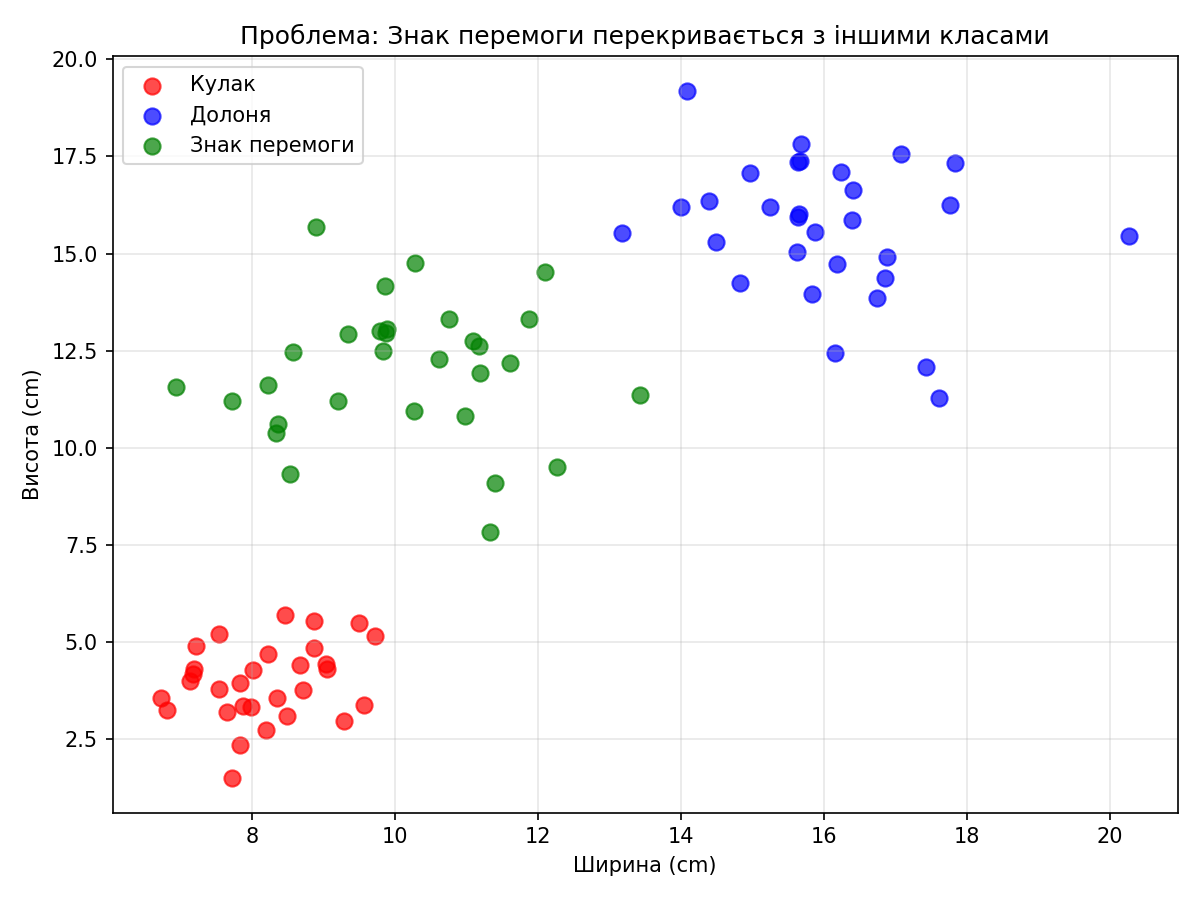

In [5]:
rng3 = RNG(777)
victory_data = [(rng3.gauss(10, 1.5), rng3.gauss(12, 2.0)) for _ in range(30)]
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(fist_w, fist_h, c='red', label='Кулак', s=60, alpha=0.7)
ax.scatter(palm_w, palm_h, c='blue', label='Долоня', s=60, alpha=0.7)
ax.scatter([p[0] for p in victory_data], [p[1] for p in victory_data], c='green', label='Знак перемоги', s=60, alpha=0.7)
ax.set_xlabel('Ширина (cm)'); ax.set_ylabel('Висота (cm)')
ax.set_title('Проблема: Знак перемоги перекривається з іншими класами')
ax.legend(); ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('victory_problem.png', dpi=150)
plt.close()
display(Image('victory_problem.png'))


## 5. k-means кластеризація


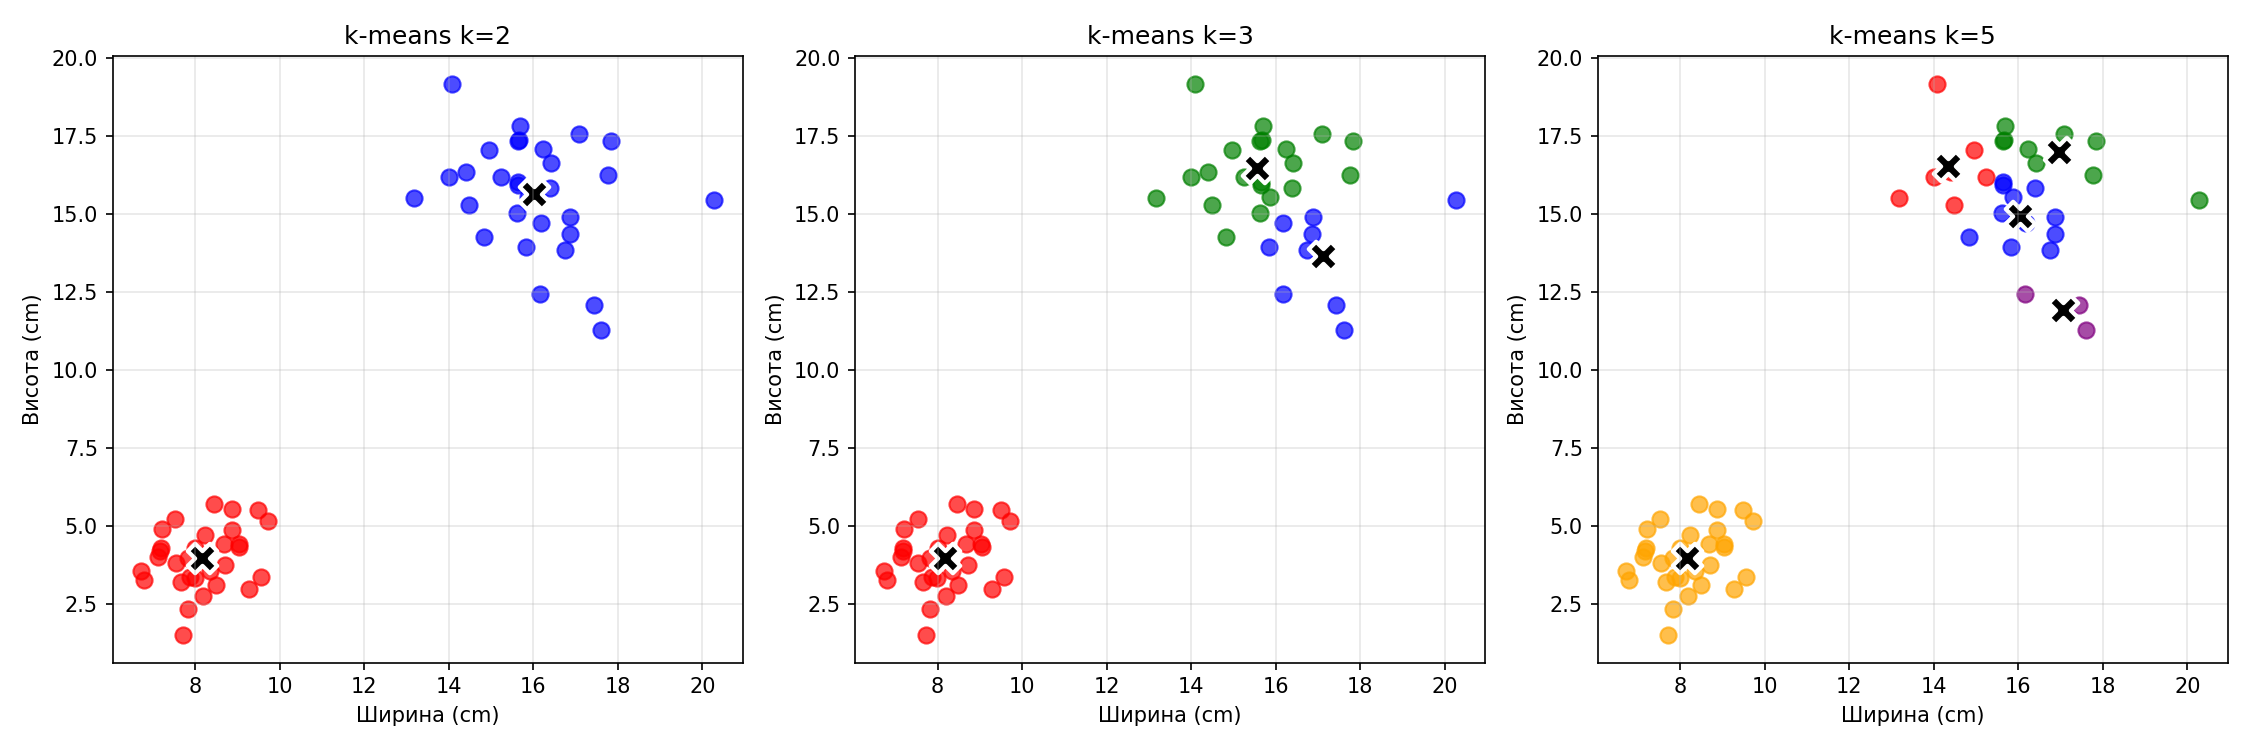

In [6]:
def kmeans(data, k, max_iter=100):
    rng_km = RNG(42 + k)
    indices = list(range(len(data)))
    for i in range(len(indices)-1, 0, -1):
        j = int(rng_km.random() * (i+1))
        indices[i], indices[j] = indices[j], indices[i]
    centroids = [data[i] for i in indices[:k]]
    for _ in range(max_iter):
        clusters = [[] for _ in range(k)]
        labels = []
        for point in data:
            nearest = min(range(k), key=lambda i: euclidean_dist(point, centroids[i]))
            labels.append(nearest)
            clusters[nearest].append(point)
        new_c = []
        for i, cl in enumerate(clusters):
            new_c.append((sum(p[0] for p in cl)/len(cl), sum(p[1] for p in cl)/len(cl)) if cl else centroids[i])
        if new_c == centroids: break
        centroids = new_c
    return labels, centroids
colors = ['red', 'blue', 'green', 'orange', 'purple']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, k in enumerate([2, 3, 5]):
    labels, centroids = kmeans(X, k)
    ax = axes[idx]
    for i, point in enumerate(X):
        ax.scatter(point[0], point[1], c=colors[labels[i]], s=60, alpha=0.7)
    for c in centroids:
        ax.scatter(c[0], c[1], c='black', marker='X', s=200, edgecolors='white', linewidths=2)
    ax.set_xlabel('Ширина (cm)'); ax.set_ylabel('Висота (cm)'); ax.set_title(f'k-means k={k}')
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('kmeans_results.png', dpi=150)
plt.close()
display(Image('kmeans_results.png'))
